**Chapter 2 – End-to-end Machine Learning project**

*Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts.*

*This notebook contains all the sample code and solutions to the exercices in chapter 2.*

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import seaborn as sns

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Get the Data

## Download the Data

In [2]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

## Take a Quick Look at the Data Structure

In [5]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Saving figure attribute_histogram_plots


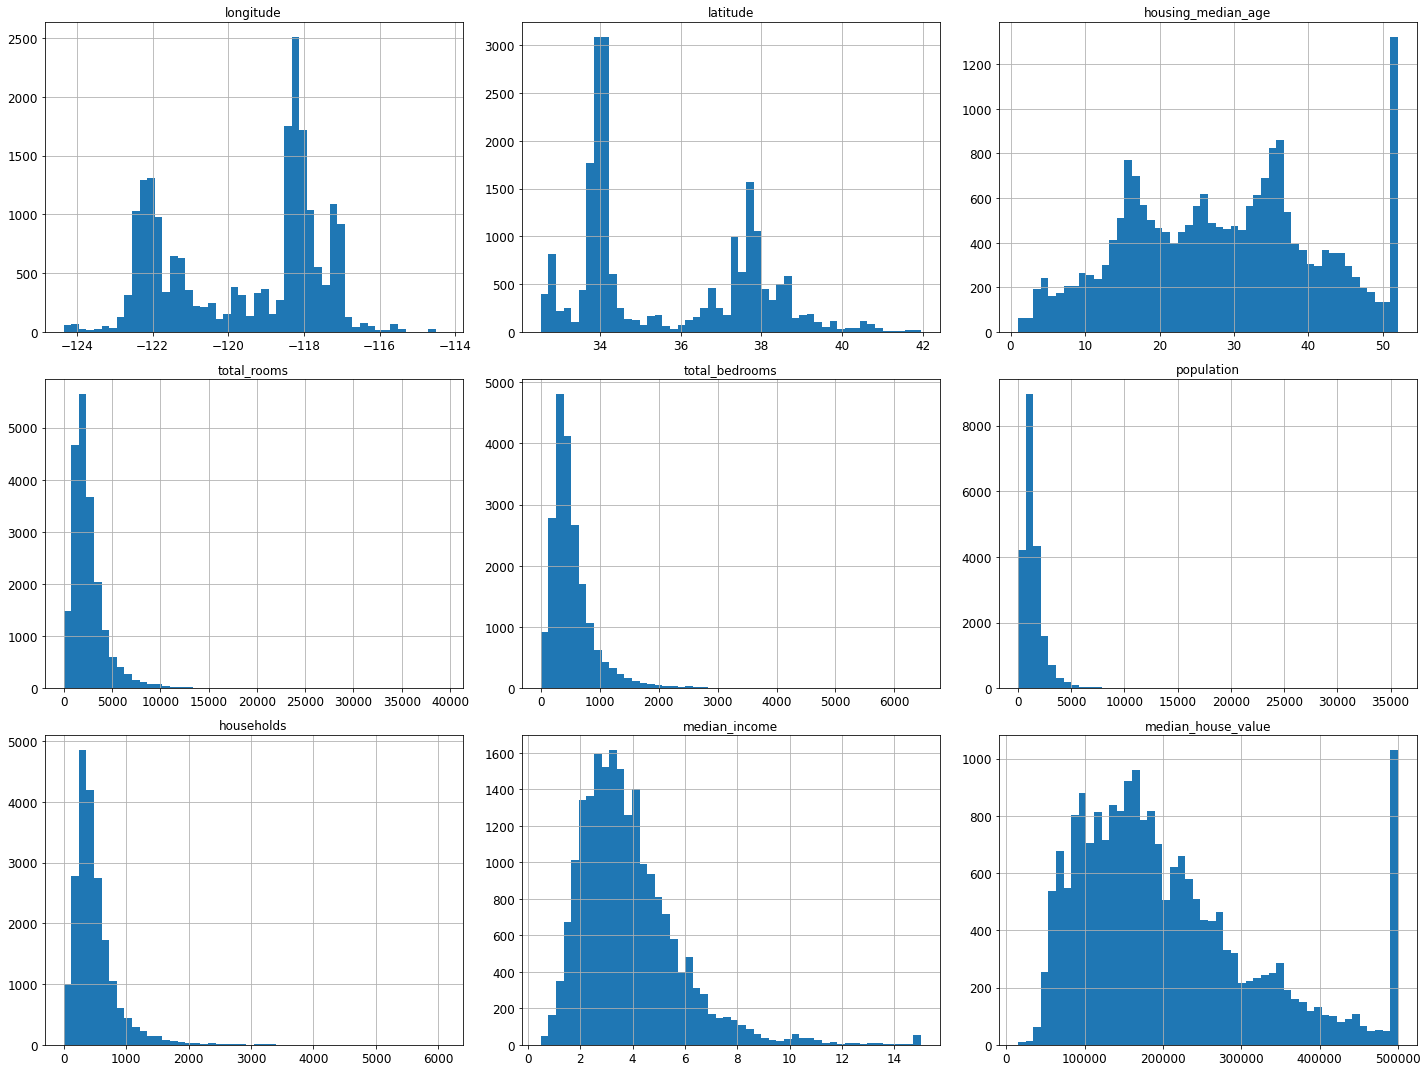

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

## Create a Test Set

In [10]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [11]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [12]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


# Discover and Visualize the Data to Gain Insights

In [13]:
housing = train_set.copy()

## Visualizing Geographical Data

The argument `sharex=False` fixes a display bug (the x-axis values and legend were not displayed). This is a temporary fix (see: https://github.com/pandas-dev/pandas/issues/10611 ). Thanks to Wilmer Arellano for pointing it out.

Saving figure housing_prices_scatterplot


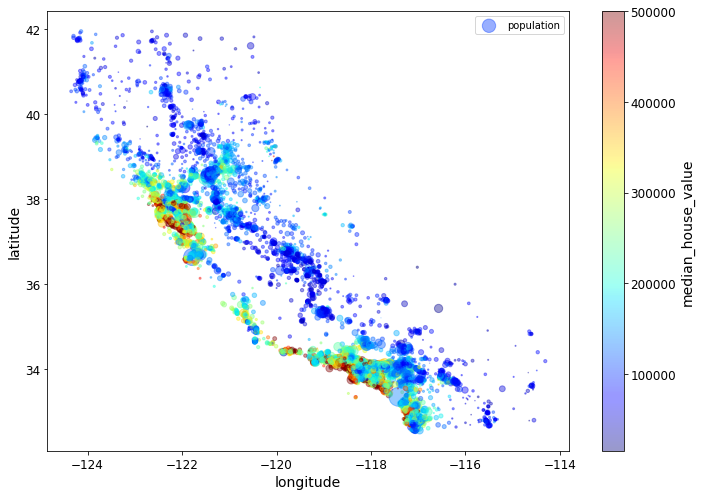

In [14]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

In [15]:
# Download the California image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('.\\images\\end_to_end_project\\california.png',
 <http.client.HTTPMessage at 0x18a93cdd6d0>)

Saving figure california_housing_prices_plot


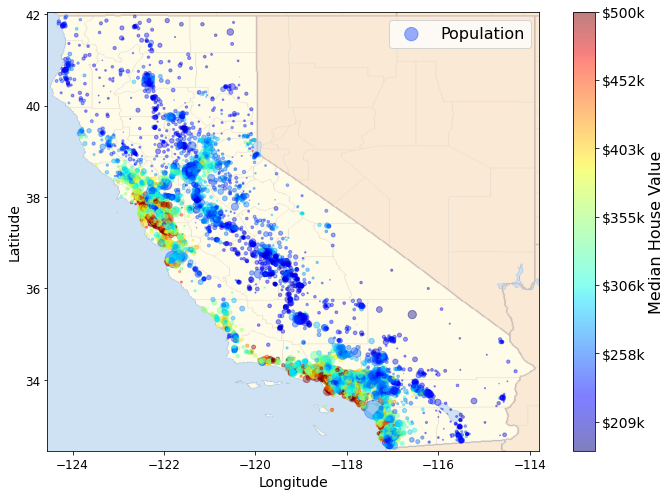

In [16]:
import matplotlib.image as mpimg
california_img=mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                  s=housing['population']/100, label="Population",
                  c="median_house_value", cmap=plt.get_cmap("jet"),
                  colorbar=False, alpha=0.4)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

## Looking for Correlations

In [17]:
corr_matrix = housing.corr()

In [18]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.690647
total_rooms           0.133989
housing_median_age    0.103706
households            0.063714
total_bedrooms        0.047980
population           -0.026032
longitude            -0.046349
latitude             -0.142983
Name: median_house_value, dtype: float64

Saving figure scatter_matrix_plot


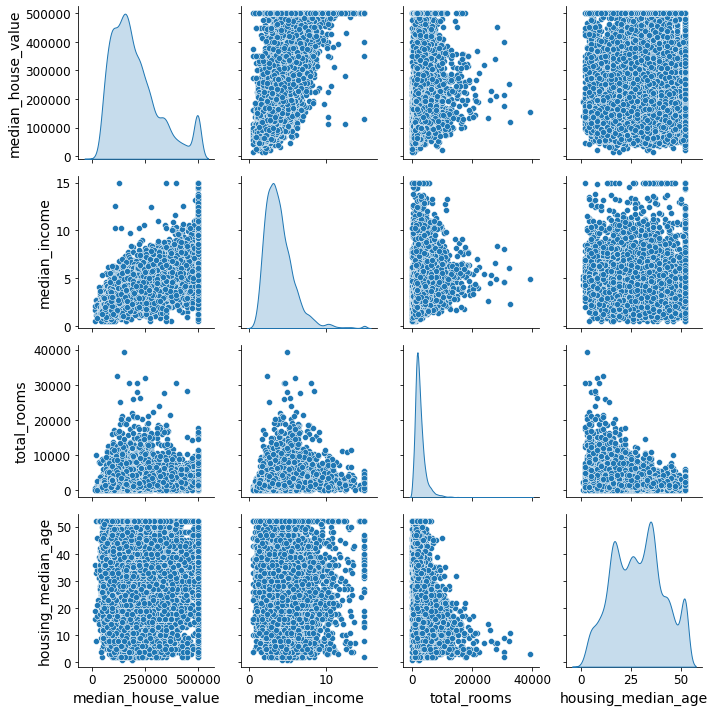

In [19]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
g = sns.pairplot(housing[attributes], diag_kind="kde")
#g.map_lower(sns.kdeplot, levels=4, color=".2")
save_fig("scatter_matrix_plot")

Saving figure income_vs_house_value_scatterplot


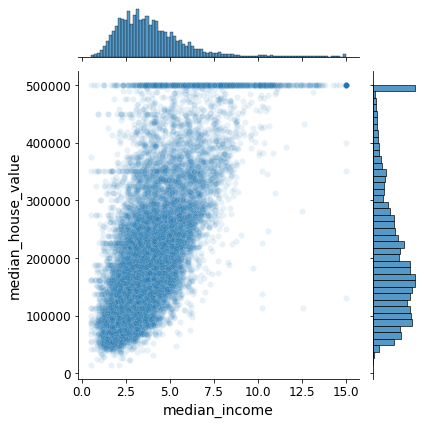

In [20]:
sns.jointplot(data=housing, x="median_income", y="median_house_value",
             alpha=0.1)
#plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

## Experimenting with Attribute Combinations

In [21]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [22]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.690647
rooms_per_household         0.158485
total_rooms                 0.133989
housing_median_age          0.103706
households                  0.063714
total_bedrooms              0.047980
population_per_household   -0.022030
population                 -0.026032
longitude                  -0.046349
latitude                   -0.142983
bedrooms_per_room          -0.257419
Name: median_house_value, dtype: float64

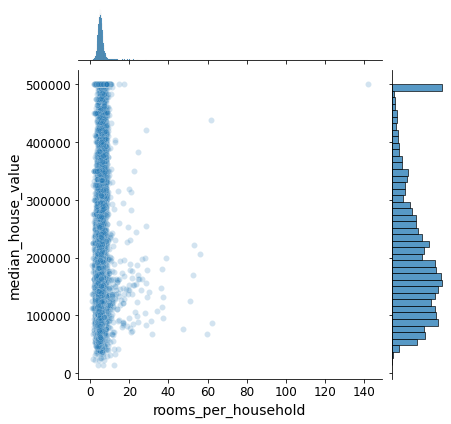

In [23]:
sns.jointplot(data=housing, x="rooms_per_household", y="median_house_value",
             alpha=0.2)
#plt.axis([0, 5, 0, 520000])
plt.show()

In [24]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.582290,35.643149,28.608285,2642.004784,538.496851,1426.453004,499.986919,3.880754,207194.693738,5.435235,0.212858,3.096961
std,2.005654,2.136665,12.602499,2174.646744,419.007096,1137.056380,380.967964,1.904294,115622.626448,2.387375,0.057995,11.578744
min,-124.350000,32.550000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.888889,0.100000,0.692308
25%,-121.810000,33.930000,18.000000,1454.000000,296.750000,789.000000,280.000000,2.566700,119800.000000,4.452055,0.175178,2.428799
50%,-118.510000,34.260000,29.000000,2129.000000,437.000000,1167.000000,410.000000,3.545800,179850.000000,5.235874,0.202808,2.817240
75%,-118.010000,37.720000,37.000000,3160.000000,647.000000,1726.000000,606.000000,4.773175,265125.000000,6.061037,0.239501,3.280000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


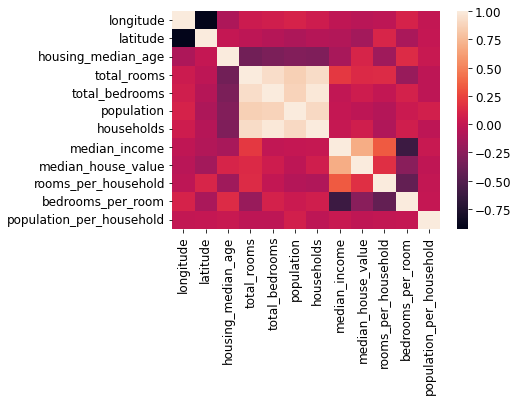

In [25]:
g = sns.heatmap(corr_matrix)

# Prepare the Data for Machine Learning Algorithms

In [26]:
housing = train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = train_set["median_house_value"].copy()

## Data Cleaning

In [27]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

Remove the text attribute because median can only be calculated on numerical attributes:

In [28]:
housing_num = housing.drop("ocean_proximity", axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

In [29]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [30]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2129.    ,  437.    , 1167.    ,
        410.    ,    3.5458])

Transform the training set:

In [31]:
X = imputer.transform(housing_num)

In [32]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [33]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542


## Handling Text and Categorical Attributes

Now let's preprocess the categorical input feature, `ocean_proximity`:

In [34]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
14196,NEAR OCEAN
8267,NEAR OCEAN
17445,NEAR OCEAN
14265,NEAR OCEAN
2271,INLAND
17848,<1H OCEAN
6252,<1H OCEAN
9389,NEAR BAY
6113,<1H OCEAN
6061,<1H OCEAN


In [37]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:

In [38]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

Alternatively, you can set `sparse=False` when creating the `OneHotEncoder`:

## Custom Transformers

Let's create a custom transformer to add extra attributes:

In [39]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

Note that I hard coded the indices (3, 4, 5, 6) for concision and clarity in the book, but it would be much cleaner to get them dynamically, like this:

In [40]:
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names] # get the column indices

Also, `housing_extra_attribs` is a NumPy array, we've lost the column names (unfortunately, that's a problem with Scikit-Learn). To recover a `DataFrame`, you could run this:

In [41]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,NEAR OCEAN,5.017657,3.691814
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,NEAR OCEAN,4.473545,1.738095
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,NEAR OCEAN,5.645833,2.723214
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,NEAR OCEAN,4.002817,3.994366
2271,-119.8,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,INLAND,6.268421,2.3


## Transformation Pipelines

Now let's build a pipeline for preprocessing the numerical attributes:

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [42]:
housing_num_tr

array([[ 1.27258656, -1.3728112 ,  0.34849025, ..., -0.17491646,
         0.05137609, -0.2117846 ],
       [ 0.70916212, -0.87669601,  1.61811813, ..., -0.40283542,
        -0.11736222,  0.34218528],
       [-0.44760309, -0.46014647, -1.95271028, ...,  0.08821601,
        -0.03227969, -0.66165785],
       ...,
       [ 0.59946887, -0.75500738,  0.58654547, ..., -0.60675918,
         0.02030568,  0.99951387],
       [-1.18553953,  0.90651045, -1.07984112, ...,  0.40217517,
         0.00707608, -0.79086209],
       [-1.41489815,  0.99543676,  1.85617335, ..., -0.85144571,
        -0.08535429,  1.69520292]])

In [43]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [44]:
housing_prepared

array([[ 1.27258656, -1.3728112 ,  0.34849025, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.70916212, -0.87669601,  1.61811813, ...,  0.        ,
         0.        ,  1.        ],
       [-0.44760309, -0.46014647, -1.95271028, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.59946887, -0.75500738,  0.58654547, ...,  0.        ,
         0.        ,  0.        ],
       [-1.18553953,  0.90651045, -1.07984112, ...,  0.        ,
         0.        ,  0.        ],
       [-1.41489815,  0.99543676,  1.85617335, ...,  0.        ,
         1.        ,  0.        ]])

In [45]:
housing_prepared.shape

(16512, 16)

# Select and Train a Model

## Training and Evaluating on the Training Set

In [46]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [47]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [181746.54359616 290558.74973505 244957.50017771 146498.51061398
 163230.42393939]


Compare against the actual values:

In [48]:
print("Labels:", list(some_labels))

Labels: [103000.0, 382100.0, 172600.0, 93400.0, 96500.0]


In [49]:
some_data_prepared

array([[ 1.27258656, -1.3728112 ,  0.34849025,  0.22256942,  0.21122752,
         0.76827628,  0.32290591, -0.326196  , -0.17491646,  0.05137609,
        -0.2117846 ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [ 0.70916212, -0.87669601,  1.61811813,  0.34029326,  0.59309419,
        -0.09890135,  0.6720272 , -0.03584338, -0.40283542, -0.11736222,
         0.34218528,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.44760309, -0.46014647, -1.95271028, -0.34259695, -0.49522582,
        -0.44981806, -0.43046109,  0.14470145,  0.08821601, -0.03227969,
        -0.66165785,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [ 1.23269811, -1.38217186,  0.58654547, -0.56148971, -0.40930582,
        -0.00743434, -0.38058662, -1.01786438, -0.60001532,  0.07750687,
         0.78303162,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.10855122,  0.5320839 ,  1

In [50]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

67593.20745775253

**Note**: since Scikit-Learn 0.22, you can get the RMSE directly by calling the `mean_squared_error()` function with `squared=False`.

In [51]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

48785.16002488508

In [52]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [53]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

## Better Evaluation Using Cross-Validation

In [54]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [55]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [65312.86044031 70581.69865676 67849.75809965 71460.33789358
 74035.29744574 65562.42978503 67964.10942543 69102.89388457
 66876.66473025 69735.84760006]
Mean: 68848.18979613911
Standard deviation: 2579.6785558576307


In [56]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [65000.67382615 70960.56056304 67122.63935124 66089.63153865
 68402.54686442 65266.34735288 65218.78174481 68525.46981754
 72739.87555996 68957.34111906]
Mean: 67828.38677377408
Standard deviation: 2468.0913950652252


In [57]:
pd.Series(lin_rmse_scores).describe()

count       10.000000
mean     67828.386774
std       2601.596761
min      65000.673826
25%      65472.168399
50%      67762.593108
75%      68849.373294
max      72739.875560
dtype: float64

# Fine-Tune Your Model

## Grid Search

In [58]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 4 values of hyperparameters
    {'max_features': [2, 4, 6, 8]},
  ]

tree_reg = DecisionTreeRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(tree_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8]}],
             return_train_score=True, scoring='neg_mean_squared_error')

The best hyperparameter combination found:

In [59]:
grid_search.best_params_

{'max_features': 8}

In [60]:
grid_search.best_estimator_

DecisionTreeRegressor(max_features=8, random_state=42)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [61]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

80764.99836970345 {'max_features': 2}
75180.15756962687 {'max_features': 4}
71713.74350539458 {'max_features': 6}
69491.89718012043 {'max_features': 8}


In [62]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.089893,0.007574,0.000784,0.001567,2,{'max_features': 2},-6.836835e+09,-6.472783e+09,-5.717496e+09,-6.664663e+09,...,-6.522985e+09,4.312858e+08,4,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
1,0.133196,0.015872,0.003883,0.006023,4,{'max_features': 4},-5.481009e+09,-5.351692e+09,-5.851880e+09,-5.344579e+09,...,-5.652056e+09,3.432963e+08,3,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
2,0.179322,0.005223,0.005772,0.006459,6,{'max_features': 6},-5.510293e+09,-5.470706e+09,-4.724508e+09,-4.895620e+09,...,-5.142861e+09,3.096828e+08,2,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
3,0.221604,0.008935,0.003210,0.006152,8,{'max_features': 8},-4.781330e+09,-4.687706e+09,-4.920127e+09,-4.539553e+09,...,-4.829124e+09,2.301254e+08,1,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0


## Randomized Search

In [63]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'max_features': randint(low=1, high=8),
    }

tree_reg = DecisionTreeRegressor(random_state=42)
rnd_search = RandomizedSearchCV(tree_reg, param_distributions=param_distribs,
                                n_iter=4, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
                   n_iter=4,
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000026CD1E584F0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [64]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

73346.72990355256 {'max_features': 7}
75180.15756962687 {'max_features': 4}
70566.51182304003 {'max_features': 5}
73346.72990355256 {'max_features': 7}


## Analyze the Best Models and Their Errors

In [65]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.09189103, 0.07772142, 0.03641293, 0.01637397, 0.01496616,
       0.01642938, 0.01227977, 0.19576153, 0.1443766 , 0.09078282,
       0.03436768, 0.00149874, 0.26067853, 0.        , 0.00126537,
       0.00519406])

In [66]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.2606785279408974, 'INLAND'),
 (0.19576152852908085, 'median_income'),
 (0.1443766047496594, 'rooms_per_hhold'),
 (0.09189103272109425, 'longitude'),
 (0.09078282491412892, 'pop_per_hhold'),
 (0.07772141678917896, 'latitude'),
 (0.03641293487805404, 'housing_median_age'),
 (0.034367680402712174, 'bedrooms_per_room'),
 (0.016429377920090513, 'population'),
 (0.01637396590940156, 'total_rooms'),
 (0.014966161919853527, 'total_bedrooms'),
 (0.012279772549517974, 'households'),
 (0.005194061275494982, 'NEAR OCEAN'),
 (0.0014987379593710461, '<1H OCEAN'),
 (0.0012653715414644219, 'NEAR BAY'),
 (0.0, 'ISLAND')]

## Evaluate Your System on the Test Set

In [68]:
final_model = grid_search.best_estimator_

X_test = test_set.drop("median_house_value", axis=1)
y_test = test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [69]:
final_rmse

68136.60028886753

We can compute a 95% confidence interval for the test RMSE:

In [70]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([65208.45882826, 70943.9884352 ])

We could compute the interval manually like this:

In [71]:
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(65208.45882825536, 70943.98843519817)

Alternatively, we could use a z-scores rather than t-scores:

In [72]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(65209.33686306689, 70943.18137586495)

# Extra material

## A full pipeline with both preparation and prediction

In [73]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([181746.54359616, 290558.74973505, 244957.50017771, 146498.51061398,
       163230.42393939])

## Model persistence using joblib

In [74]:
my_model = full_pipeline_with_predictor

In [75]:
import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

## 3.

Question: Try adding a transformer in the preparation pipeline to select only the most important attributes.

In [76]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

Note: this feature selector assumes that you have already computed the feature importances somehow (for example using a `RandomForestRegressor`). You may be tempted to compute them directly in the `TopFeatureSelector`'s `fit()` method, however this would likely slow down grid/randomized search since the feature importances would have to be computed for every hyperparameter combination (unless you implement some sort of cache).

Let's define the number of top features we want to keep:

In [77]:
k = 5

Now let's look for the indices of the top k features:

In [78]:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 0,  7,  8,  9, 12], dtype=int64)

In [79]:
np.array(attributes)[top_k_feature_indices]

array(['longitude', 'median_income', 'rooms_per_hhold', 'pop_per_hhold',
       'INLAND'], dtype='<U18')

Let's double check that these are indeed the top k features:

In [80]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(0.2606785279408974, 'INLAND'),
 (0.19576152852908085, 'median_income'),
 (0.1443766047496594, 'rooms_per_hhold'),
 (0.09189103272109425, 'longitude'),
 (0.09078282491412892, 'pop_per_hhold')]

Looking good... Now let's create a new pipeline that runs the previously defined preparation pipeline, and adds top k feature selection:

In [81]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [82]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

Let's look at the features of the first 3 instances:

In [83]:
housing_prepared_top_k_features[0:3]

array([[ 1.27258656, -0.326196  , -0.17491646,  0.05137609,  0.        ],
       [ 0.70916212, -0.03584338, -0.40283542, -0.11736222,  0.        ],
       [-0.44760309,  0.14470145,  0.08821601, -0.03227969,  0.        ]])

Now let's double check that these are indeed the top k features:

In [84]:
housing_prepared[0:3, top_k_feature_indices]

array([[ 1.27258656, -0.326196  , -0.17491646,  0.05137609,  0.        ],
       [ 0.70916212, -0.03584338, -0.40283542, -0.11736222,  0.        ],
       [-0.44760309,  0.14470145,  0.08821601, -0.03227969,  0.        ]])

Works great!  :)

## 4.

Question: Try creating a single pipeline that does the full data preparation plus the final prediction.

In [85]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

NameError: name 'SVR' is not defined

In [ ]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Let's try the full pipeline on a few instances:

In [ ]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Well, the full pipeline seems to work fine. Of course, the predictions are not fantastic: they would be better if we used the best `RandomForestRegressor` that we found earlier, rather than the best `SVR`.

## 5.

Question: Automatically explore some preparation options using `GridSearchCV`.

**Warning**: the following cell may take close to 45 minutes to run, or more depending on your hardware.

**Note:** In the code below, I've set the `OneHotEncoder`'s `handle_unknown` hyperparameter to `'ignore'`, to avoid warnings during training. Without this, the `OneHotEncoder` would default to `handle_unknown='error'`, meaning that it would raise an error when transforming any data containing a category it didn't see during training. If we kept the default, then the `GridSearchCV` would run into errors during training when evaluating the folds in which not all the categories are in the training set. This is likely to happen since there's only one sample in the `'ISLAND'` category, and it may end up in the test set in some of the folds. So some folds would just be dropped by the `GridSearchCV`, and it's best to avoid that.

In [ ]:
full_pipeline.named_transformers_["cat"].handle_unknown = 'ignore'

param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2)
grid_search_prep.fit(housing, housing_labels)

In [ ]:
grid_search_prep.best_params_

The best imputer strategy is `most_frequent` and apparently almost all features are useful (15 out of 16). The last one (`ISLAND`) seems to just add some noise.

Congratulations! You already know quite a lot about Machine Learning. :)